In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchsummary import summary

import numpy as np

import optuna

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Define image transformations (including normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load training and test data
full_train_data = datasets.MNIST(root=".\MNIST\MNIST_Train", train=True, download=False, transform = transform)
test_data = datasets.MNIST(root=".\MNIST\MNIST_Test", train=False, download=False, transform = transform)

# Set the seed for reproducibility
torch.manual_seed(42)  # You can choose any seed number

# Defining the sets that are going to be used for training and gridsearch
train_data = int(0.7 * len(full_train_data))  # 70% for training
train_gridsearch = len(full_train_data) - train_data # 30% for gridsearch
# Get the training and gridsearch sets
train_data, train_gridsearch = random_split(full_train_data, [train_data, train_gridsearch])

# Make the Training and Validation split of the train_gridsearch set
train_gridsearch2 = int(0.8 * len(train_gridsearch))  # 80% for training (gridsearch)
validation_gridsearch = len(train_gridsearch) - train_gridsearch2  # 20% for validation (gridsearch)
# Get the grid search sets
train_gridsearch2, validation_gridsearch = random_split(train_gridsearch, [train_gridsearch2, validation_gridsearch])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Number of images for total training:", len(full_train_data))
print("  |  Number of images for gridsearch:", len(train_gridsearch))
print("  |    |  Number of images for gridsearch training:", len(train_gridsearch2))
print("  |    |  Number of images for gridsearch validation:", len(validation_gridsearch))
print("  |  Number of images for training data after gridsearch:", len(train_data))
print("Number of images for testing:", len(test_data))

In [3]:
class CNNEncoder(nn.Module): # Encoder as we're only interested in the final embedding provided by the CNN 
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(256 * 7 * 7, 128)  # Output: 128-dimension embeddings

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 14x14
        
        x = self.dropout1(F.relu(self.conv3(x))) #Adding Drop out
        x = F.relu(self.conv4(x))
        x = self.pool(x)  # 7x7
        
        x = x.view(-1, 256 * 7 * 7)  # Flatten
        x = self.fc(x)  # Output embeddings
        
         # Normalize embeddings to lie on unit hypersphere
        x = F.normalize(x, p=2, dim=1)  # L2 normalization
        
        return x

class MLPClassifier(nn.Module): # MLP projection Head 
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.dropout2(F.relu(self.fc1(x))) #Adding Drop out
        x = self.fc2(x)
        return x

In [4]:
class CNNModel(nn.Module):
    def __init__(self, encoder, classifier, optimizer):
        super(CNNModel, self).__init__()
        self.encoder = encoder
        self.classifier = classifier
        self.optimizer = optimizer
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.encoder(x)  # First pass through the encoder to get the embeddings
        x = self.classifier(x)  # Then pass the embeddings through the classifier
        return x

    def train_step(self, x, y):
        """Performs one training step: forward pass, loss calculation, backpropagation, and optimization"""
        self.optimizer.zero_grad()  # Clear gradients
        output = self.forward(x)    # Forward pass
        loss = self.loss_fn(output, y)  # Calculate loss
        loss.backward()             # Backpropagation
        self.optimizer.step()       # Update the model parameters
        return loss.item()          # Return the loss value for monitoring

    def test_step(self, x, y):
        """Performs one testing step: forward pass and loss calculation"""
        with torch.no_grad():  # Disable gradient calculation for testing/evaluation
            output = self.forward(x)  # Forward pass
            loss = self.loss_fn(output, y)  # Calculate loss
            predicted = torch.argmax(output, dim=1)  # Get predicted class
            correct = (predicted == y).sum().item()  # Calculate the number of correct predictions
            total = y.size(0)  # Total number of samples
        return loss.item(), correct, total  # Return loss, correct predictions, and total samples

    def train_model(self, train_loader, epochs):
        """Train the model for a number of epochs"""
        self.train()  # Set model to training mode (this does NOT call this method itself)
        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                x, y = batch
                loss = self.train_step(x, y)  # Perform training step
                total_loss += loss
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")  # Print average loss per epoch

    def test_model(self, test_loader, num_classes=10):
        self.encoder.eval()
        self.classifier.eval()
        
        # Variables to store predictions and true labels for AUC/ROC/Confusion Matrix
        all_probs = []
        all_labels = []
        all_preds = []
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Get features and outputs
                features = self.encoder(images)
                outputs = self.classifier(features)
                
                # Convert logits to probabilities using softmax
                probs = F.softmax(outputs, dim=1)
                
                # Record the true labels and predicted probabilities
                all_labels.append(labels.cpu().numpy())
                all_probs.append(probs.cpu().numpy())
                
                # Get predicted class from the output (class with max probability)
                _, predicted = torch.max(outputs, 1)
                all_preds.append(predicted.cpu().numpy())
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Flatten the collected lists
        all_labels = np.concatenate(all_labels)
        all_probs = np.concatenate(all_probs)
        all_preds = np.concatenate(all_preds)
        
        # Calculate test accuracy
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        
        # --- ROC and AUC computation ---
        # One-hot encode the labels
        labels_one_hot = np.eye(num_classes)[all_labels]

        # Compute ROC and AUC for each class
        roc_auc = {}
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(labels_one_hot[:, i], all_probs[:, i])
            auc = roc_auc_score(labels_one_hot[:, i], all_probs[:, i])
            roc_auc[f'Class {i}'] = auc
            print(f'Class {i} AUC: {auc:.4f}')
            
            # Plot the ROC curve for each class
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        
        # Overall macro AUC score
        overall_auc = roc_auc_score(labels_one_hot, all_probs, average='macro')
        print(f'Overall AUC (macro): {overall_auc:.4f}')
        
        # --- Confusion Matrix ---
        # Compute confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(num_classes))
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

In [5]:
# Hyperparameter tuning with Optuna
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 256, step=16)
    
    # Create data loaders
    train_loader = DataLoader(train_gridsearch2, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_gridsearch, batch_size=batch_size, shuffle=False)
    
    encoder = CNNEncoder().to(device)
    classifier = MLPClassifier().to(device)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=lr)
    
    trainer = CNNModel(encoder, classifier, optimizer)
    
    # Train the model
    trainer.train_model(train_loader, epochs=10)  # Use train_model instead of train
    
    # Evaluate on validation data
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            features = encoder(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [4]:
model_encoder = CNNEncoder()
summary(model_encoder, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
           Dropout-5          [-1, 128, 14, 14]               0
            Conv2d-6          [-1, 256, 14, 14]         295,168
         MaxPool2d-7            [-1, 256, 7, 7]               0
            Linear-8                  [-1, 128]       1,605,760
Total params: 1,993,600
Trainable params: 1,993,600
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.53
Params size (MB): 7.60
Estimated Total Size (MB): 9.14
----------------------------------------------------------------


In [11]:
model_projection = MLPClassifier()
summary(model_projection, input_size=(1, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           8,256
           Dropout-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 10]             650
Total params: 8,906
Trainable params: 8,906
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [7]:
# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-10-19 20:36:14,002] A new study created in memory with name: no-name-43a0ee11-453c-4110-8d00-9251cb6e2095


Epoch 1/10, Loss: 2.123171569506327
Epoch 2/10, Loss: 1.7833926518758139
Epoch 3/10, Loss: 1.3805916118621826
Epoch 4/10, Loss: 0.9783353050549825
Epoch 5/10, Loss: 0.6549519284566243
Epoch 6/10, Loss: 0.432391349474589
Epoch 7/10, Loss: 0.2939144710699717
Epoch 8/10, Loss: 0.20750270664691925
Epoch 9/10, Loss: 0.15391453603903452
Epoch 10/10, Loss: 0.11495867520570754


[I 2024-10-19 20:45:32,855] Trial 0 finished with value: 0.9855555555555555 and parameters: {'lr': 0.0002333045759463599, 'batch_size': 192}. Best is trial 0 with value: 0.9855555555555555.


Epoch 1/10, Loss: 2.2168875408172606
Epoch 2/10, Loss: 2.146507698694865
Epoch 3/10, Loss: 2.1070744228363036
Epoch 4/10, Loss: 2.0717541440327962
Epoch 5/10, Loss: 2.03873997370402
Epoch 6/10, Loss: 2.00503782749176
Epoch 7/10, Loss: 1.9723741436004638
Epoch 8/10, Loss: 1.937910763422648
Epoch 9/10, Loss: 1.9018522357940675
Epoch 10/10, Loss: 1.8645174312591553


[I 2024-10-19 20:53:26,022] Trial 1 finished with value: 0.9455555555555556 and parameters: {'lr': 2.6656993531018744e-05, 'batch_size': 192}. Best is trial 0 with value: 0.9855555555555555.


Epoch 1/10, Loss: 0.6558561083674431
Epoch 2/10, Loss: 0.12365856448809306
Epoch 3/10, Loss: 0.06928316223124663
Epoch 4/10, Loss: 0.0576799757944213
Epoch 5/10, Loss: 0.03892730899672541
Epoch 6/10, Loss: 0.04111475115434991
Epoch 7/10, Loss: 0.035545181262099906
Epoch 8/10, Loss: 0.02706146899352057
Epoch 9/10, Loss: 0.02085368169264661
Epoch 10/10, Loss: 0.01818465852489074


[I 2024-10-19 21:01:23,435] Trial 2 finished with value: 0.9841666666666666 and parameters: {'lr': 0.0026304541046815104, 'batch_size': 64}. Best is trial 0 with value: 0.9855555555555555.


Epoch 1/10, Loss: 2.3085605110440937
Epoch 2/10, Loss: 2.3050610644476754
Epoch 3/10, Loss: 2.305735663005284
Epoch 4/10, Loss: 2.3052788972854614
Epoch 5/10, Loss: 2.3055243798664637
Epoch 6/10, Loss: 2.3067746332713535
Epoch 7/10, Loss: 2.3061780861445835
Epoch 8/10, Loss: 2.304580170767648
Epoch 9/10, Loss: 2.304812482425145
Epoch 10/10, Loss: 2.3043432644435335


[I 2024-10-19 21:09:09,231] Trial 3 finished with value: 0.09944444444444445 and parameters: {'lr': 0.09195169479591606, 'batch_size': 208}. Best is trial 0 with value: 0.9855555555555555.


Epoch 1/10, Loss: 2.244162358735737
Epoch 2/10, Loss: 2.1720948177471495
Epoch 3/10, Loss: 2.140688101450602
Epoch 4/10, Loss: 2.1162822288379335
Epoch 5/10, Loss: 2.094901913090756
Epoch 6/10, Loss: 2.075592609873989
Epoch 7/10, Loss: 2.0564680057659483
Epoch 8/10, Loss: 2.037822873968827
Epoch 9/10, Loss: 2.020032476960567
Epoch 10/10, Loss: 2.001066810206363


[I 2024-10-19 21:18:37,061] Trial 4 finished with value: 0.8991666666666667 and parameters: {'lr': 1.896119369918662e-05, 'batch_size': 256}. Best is trial 0 with value: 0.9855555555555555.


Best hyperparameters:  {'lr': 0.0002333045759463599, 'batch_size': 192}


Epoch 1/10, Loss: 1.7823298581658977
Epoch 2/10, Loss: 0.7327904818264861
Epoch 3/10, Loss: 0.24990824368446385
Epoch 4/10, Loss: 0.11776357923196332
Epoch 5/10, Loss: 0.07065545599142166
Epoch 6/10, Loss: 0.04732751060430318
Epoch 7/10, Loss: 0.03455988558426023
Epoch 8/10, Loss: 0.026679166707478157
Epoch 9/10, Loss: 0.022195609766972935
Epoch 10/10, Loss: 0.01820084890223121
Test Accuracy: 99.26%
Class 0 AUC: 1.0000
Class 1 AUC: 1.0000
Class 2 AUC: 1.0000
Class 3 AUC: 1.0000
Class 4 AUC: 0.9999
Class 5 AUC: 0.9999
Class 6 AUC: 0.9999
Class 7 AUC: 0.9997
Class 8 AUC: 1.0000
Class 9 AUC: 0.9999


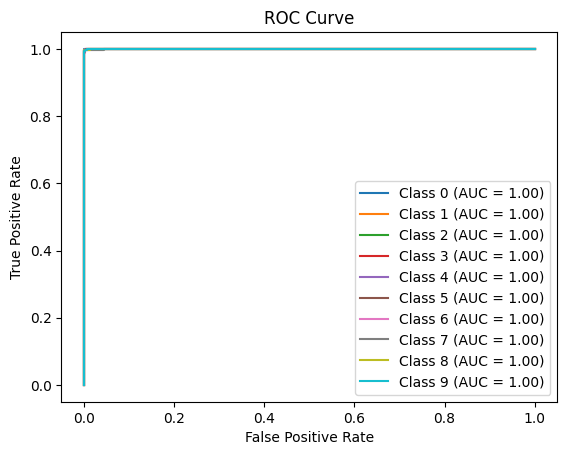

Overall AUC (macro): 0.9999


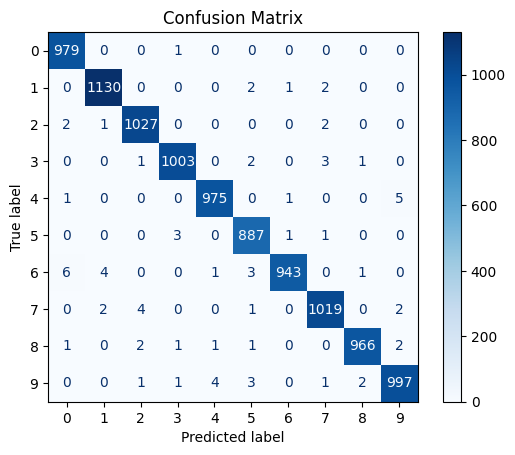

In [8]:
# Use best hyperparameters to train the final model
best_params = study.best_params
train_loader = DataLoader(train_data, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_data, batch_size=best_params['batch_size'], shuffle=False)

# Get model parameters
encoder = CNNEncoder().to(device)
classifier = MLPClassifier().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=best_params['lr'])

# Build the model to be trained
trainer = CNNModel(encoder, classifier, optimizer)

# Final training and testing
trainer.train_model(train_loader, epochs=10)
trainer.test_model(test_loader)

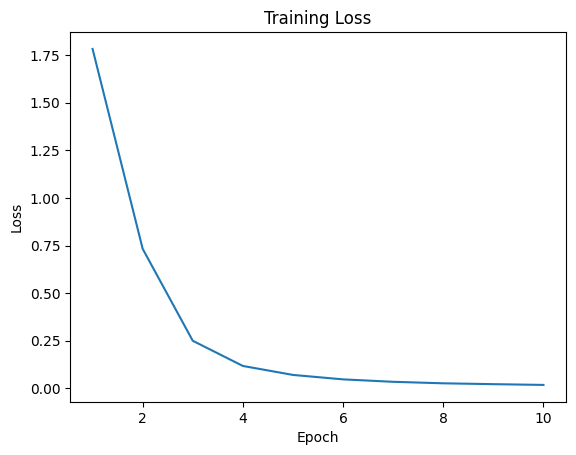

In [12]:
plt.plot([1,2,3,4,5,6,7,8,9,10], [1.7823298581658977,
                                  0.7327904818264861,
                                  0.24990824368446385,
                                  0.11776357923196332,
                                  0.07065545599142166,
                                  0.04732751060430318,
                                  0.03455988558426023,
                                  0.026679166707478157,
                                  0.022195609766972935,
                                  0.01820084890223121])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()